# Mobile price prediction

### Обозначения:
* Product_id: ID телефона
* Price: цена телефона
* Sale: количество продаж
* weight: вес телефона
* resoloution: разрешение экрана телефона
* ppi: плотность пискелей экрана
* cpu core: количество ядер процессора
* cpu freq: частота процессора, ГГц
* internal mem: внутренняя память телефона
* ram: оперативная память телефона
* RearCam: основная камера
* Front_Cam: фронтальная камера
* battery: емкость аккумулятора, мАч
* thickness: толщина телефона

In [60]:
#выгрузим данные
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [61]:
#установим параметры для будущих графиков
custom_params = {"axes.spines.right": False, "axes.spines.top": False,"axes.spines.left":False}
sns.set_theme(style="ticks", palette="pastel",color_codes=True)
plt.rcParams['figure.figsize'] = (8, 6)

In [62]:
#просмотрим наши данные
df = pd.read_csv('Mobile Price Prediction.csv')
df

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.20,424,8,1.350,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.00,233,2,1.300,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.70,312,4,1.200,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.00,233,2,1.300,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.00,233,2,1.300,4.0,1.000,3.15,0.0,1700,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1206,3551,4638,178.0,5.46,538,4,1.875,128.0,6.000,12.00,16.0,4080,8.4
157,1296,3211,8016,170.0,5.50,534,4,1.975,128.0,6.000,20.00,8.0,3400,7.9
158,856,3260,8809,150.0,5.50,401,8,2.200,64.0,4.000,20.00,20.0,3000,6.8
159,1296,3211,8946,170.0,5.50,534,4,1.975,128.0,6.000,20.00,8.0,3400,7.9


In [63]:
#заменим наименования столбцов
df.columns = ['product_id', 'price', 'sale', 'weight', 'resoloution', 'ppi',
       'cpu core', 'cpu freq', 'internal mem', 'ram', 'rearcam', 'front_cam',
       'battery', 'thickness']

In [64]:
#удалим столбец с id товара, так как было решено, что он не влияет на цену товара
df = df.drop(columns='product_id')

In [65]:
#просмотрим общую информацию о нашем датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         161 non-null    int64  
 1   sale          161 non-null    int64  
 2   weight        161 non-null    float64
 3   resoloution   161 non-null    float64
 4   ppi           161 non-null    int64  
 5   cpu core      161 non-null    int64  
 6   cpu freq      161 non-null    float64
 7   internal mem  161 non-null    float64
 8   ram           161 non-null    float64
 9   rearcam       161 non-null    float64
 10  front_cam     161 non-null    float64
 11  battery       161 non-null    int64  
 12  thickness     161 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 16.5 KB


In [66]:
#проверим на дубликаты
df.duplicated().sum()

0

In [67]:
#проверим на пропуски
df.isna().sum()

price           0
sale            0
weight          0
resoloution     0
ppi             0
cpu core        0
cpu freq        0
internal mem    0
ram             0
rearcam         0
front_cam       0
battery         0
thickness       0
dtype: int64

In [68]:
#посчитаем количество выбросов
q75 = np.percentile(df['price'], 75)
q25 = np.percentile(df['price'], 25)
iqr = q75 - q25
ejection_h = q75 + iqr*1.5
ejection_l = q25 - iqr*1.5
h_ejection = df['price'][df['price'] > ejection_h].count()
l_ejection = df['price'][df['price'] < ejection_l].count()
print(f'Число выбросов равно {h_ejection + l_ejection}. Это {(h_ejection*100/df.shape[0]).round()}% от общего числа наблюдений.')

Число выбросов равно 2. Это 1.0% от общего числа наблюдений.


<Axes: >

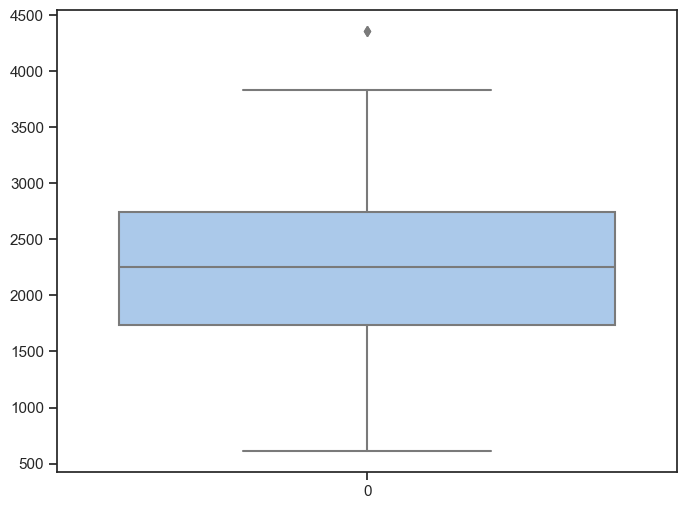

In [69]:
#построим "ящик с усами" для цены
sns.boxplot(df['price'])

In [70]:
#построим модель цены на основе линейной регрессии
selected_features = ['sale', 'weight', 'resoloution', 'ppi',
       'cpu core', 'cpu freq', 'internal mem', 'ram', 'rearcam', 'front_cam',
       'battery', 'thickness']
x = df[selected_features]
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
coefficients = model.coef_
inter = model.intercept_

print(coefficients, inter)

[-1.84340840e-02 -5.71234073e-01 -6.20319868e+01  1.10946826e+00
  5.01616044e+01  1.32497966e+02  5.61384517e+00  1.01662722e+02
  3.70502751e+00  7.18737795e+00  1.23652718e-01 -6.95683429e+01] 1667.7756524092003


In [71]:
#оценим точность нашей модели
model.score(x_train, y_train)

0.9516006085915757

In [72]:
model.score(x_test, y_test)

0.96140251348508

In [73]:
#удалим выбросы, т.к. 1% - это не критичный процент для нашего исследования
df = df[(df['price'] <= ejection_h) & (df['price'] >= ejection_l)].reset_index(drop=True)
df

,price,sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,rearcam,front_cam,battery,thickness
0,2357,10,135.0,5.20,424,8,1.350,16.0,3.000,13.00,8.0,2610,7.4
1,1749,10,125.0,4.00,233,2,1.300,4.0,1.000,3.15,0.0,1700,9.9
2,1916,10,110.0,4.70,312,4,1.200,8.0,1.500,13.00,5.0,2000,7.6
3,1315,11,118.5,4.00,233,2,1.300,4.0,0.512,3.15,0.0,1400,11.0
4,1749,11,125.0,4.00,233,2,1.300,4.0,1.000,3.15,0.0,1700,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,3551,4638,178.0,5.46,538,4,1.875,128.0,6.000,12.00,16.0,4080,8.4
155,3211,8016,170.0,5.50,534,4,1.975,128.0,6.000,20.00,8.0,3400,7.9
156,3260,8809,150.0,5.50,401,8,2.200,64.0,4.000,20.00,20.0,3000,6.8
157,3211,8946,170.0,5.50,534,4,1.975,128.0,6.000,20.00,8.0,3400,7.9


In [74]:
#опять построим модель линейной регрессии
selected_features = ['sale', 'weight', 'resoloution', 'ppi',
       'cpu core', 'cpu freq', 'internal mem', 'ram', 'rearcam', 'front_cam',
       'battery', 'thickness']
x = df[selected_features]
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
coefficients = model.coef_
inter = model.intercept_

print(coefficients, inter)

[-1.49772407e-02 -2.59877147e-01 -5.89000168e+01  1.27330412e+00
  5.64619578e+01  1.29297499e+02  5.70867549e+00  1.02024840e+02
  1.70087664e+00  7.15783511e+00  9.31090065e-02 -7.00582977e+01] 1610.61786550863


In [75]:
#проверим получившуюся точность
model.score(x_train, y_train)

0.9485108155867611

In [77]:
model.score(x_test, y_test)

0.9499135860241924

In [81]:
scores = []
depth = []
for i in range(1, 10):
    d_model=DecisionTreeRegressor(max_depth=i)
    dt_model=d_model.fit(x_train,y_train)
    depth.append(i)
    scores.append(d_model.score(x_test, y_test))
index = scores.index(max(scores))
depth[index]

6

In [82]:
    d_model=DecisionTreeRegressor(max_depth=i)
    dt_model=d_model.fit(x_train,y_train)
    depth.append(i)
    scores.append(model.score(x_test, y_test))

In [83]:
#посмотрим, как изменится показатель, если применить не линейную регрессию, а дерево решений
d_model=DecisionTreeRegressor(max_depth=6)
dt_model=d_model.fit(x_train,y_train)

In [84]:
dt_model.score(x_train, y_train)

0.9865183761693249

In [85]:
dt_model.score(x_test, y_test)

0.9731038872921525

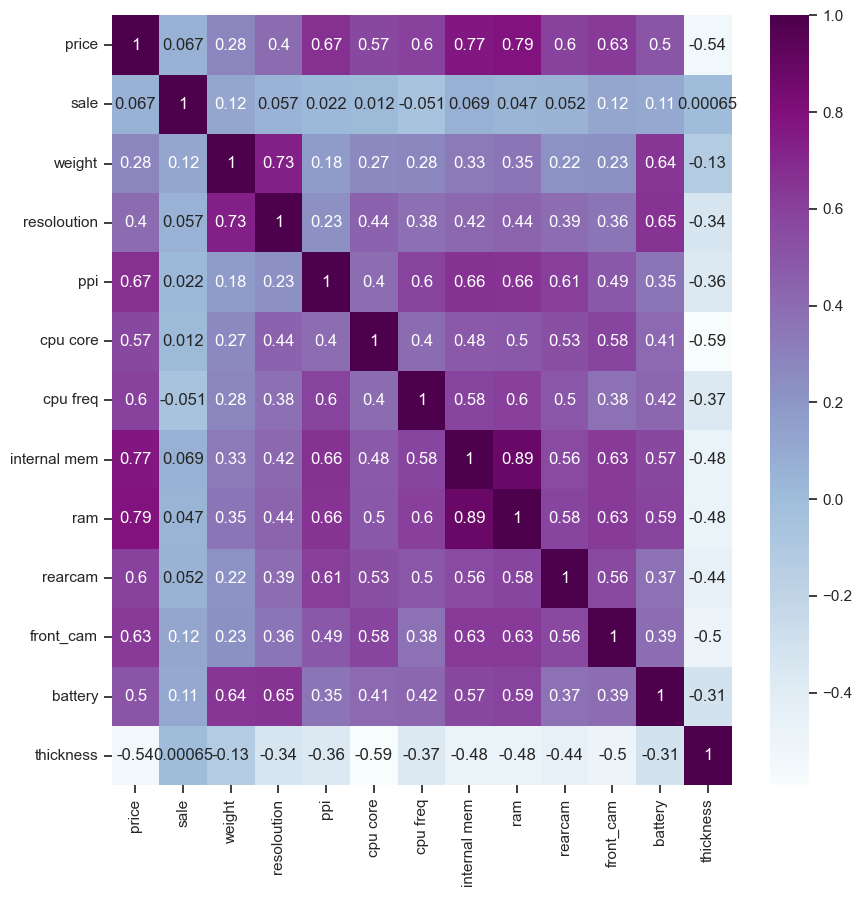

In [86]:
#построим матрицу корреляций для нашего датасета
plt.figure(figsize=(10,10))
corr_matrix = df.corr(method='kendall')
sns.heatmap(corr_matrix, annot=True, linecolor='white', cmap="BuPu")
plt.show()

In [87]:
#отберем факторы, корреляция между которыми не превышает корреляцию с фактором-результатом
df2 = df[['price', 'sale', 'resoloution', 'cpu freq', 'rearcam', 'thickness']]

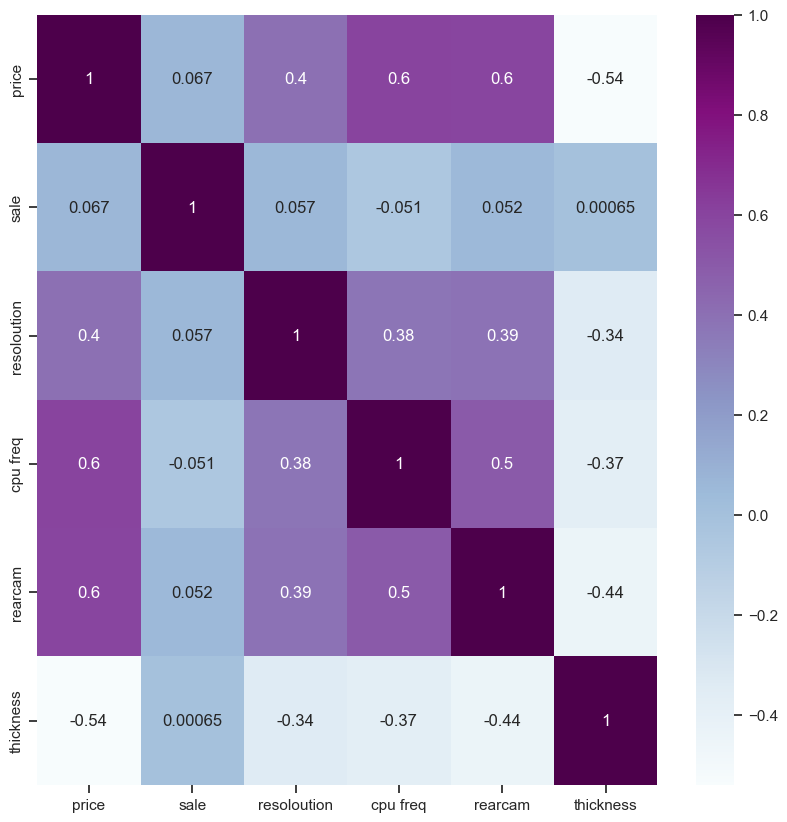

In [88]:
#построим матрицу корреляций для нового датасета
plt.figure(figsize=(10,10))
corr_matrix2 = df2.corr(method='kendall')
sns.heatmap(corr_matrix2, annot=True, linecolor='white', cmap="BuPu")
plt.show()

In [89]:
#построим модель на основе линейной регрессии
selected_features = ['sale', 'resoloution', 'cpu freq', 'rearcam', 'thickness']
x = df[selected_features]
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
coefficients = model.coef_
inter = model.intercept_

print(coefficients, inter)

[ 4.13125658e-02 -1.50106917e+01  3.71294824e+02  4.25798620e+01
 -1.27145201e+02] 2379.736799004107


In [90]:
#проверим получившуюся модель на точность
model.score(x_train, y_train)

0.7521744232052525

In [91]:
model.score(x_test, y_test)

0.8417921268654015

In [92]:
y_pred = model.predict(x_test)

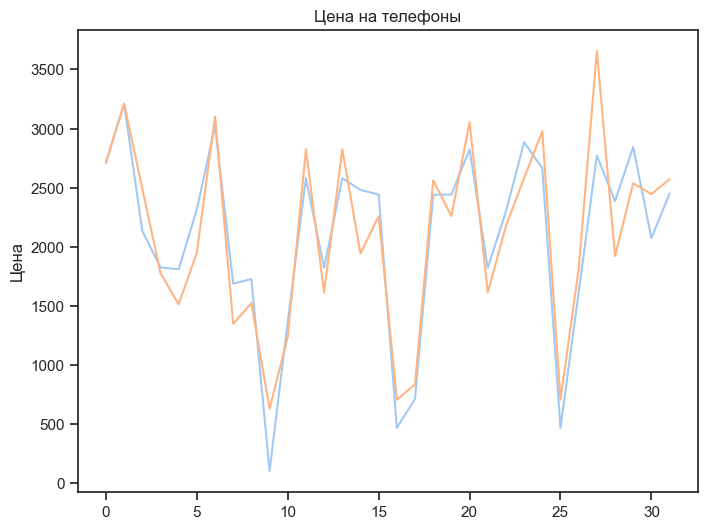

Mean Squared Error: 95685.86921990385


In [93]:
#отобразим на графике прогнозируемые и фактические значения
plt.plot(y_pred, label='Прогноз')
plt.plot(y_test.values, label='Значения')

plt.title('Цена на телефоны')
plt.ylabel('Цена')

plt.show()

#рассчитаем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [94]:
#построим модель на дереве решений
d_model=DecisionTreeRegressor(max_depth=7)
dt_model=d_model.fit(x_train,y_train)

In [30]:
#проверим r^2
dt_model.score(x_train, y_train)

0.9861499580986988

In [31]:
dt_model.score(x_test, y_test)

0.8841760510056222

In [32]:
y_pred2 = dt_model.predict(x_test)

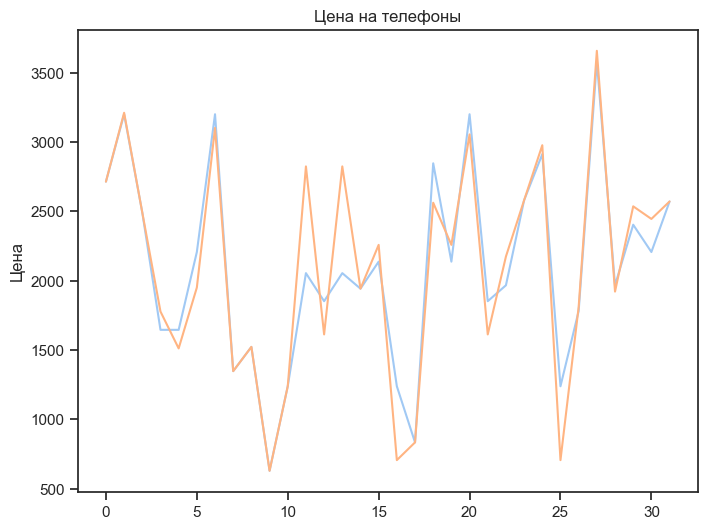

Mean Squared Error: 70051.60373137686


In [34]:
#отобразим на графике прогнозируемые и фактические значения
plt.plot(y_pred2, label='Прогноз')
plt.plot(y_test.values, label='Значения')

plt.title('Цена на телефоны')
plt.ylabel('Цена')

plt.show()

#рассчитаем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred2)
print("Mean Squared Error:", mse)